# Accessing HTAN scRNA-seq with BQ and building Scanpy AnnData objects

```
Title:   Accessing HTAN scRNA-seq with BQ and building Scanpy AnnData objects.
Author:  David L Gibbs (david.gibbs@systemsbiology.org)
Created: 2022-3-29
Purpose: Building AnnData objects
URL:     
Notes:   
```

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer MoonshotSM initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease. [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) 

This notebook shows one example of how data can be accessed and analyzed using Python.

### 1.1 Goal

The goal of this notebook is to show the user how HTAN data can be used to produce the super cool analysis pipline in python.

### 1.2 Inputs, Outputs, & Data

Inputs for this analysis include:
Some super cool data from x and y.

### 1.3 Notes 
In this notebook, we perform a sequence of queries to explore the data and follow a line of questions.</style>


In [5]:
# Center figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 2. Environment & Module Setup

In [6]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import scanpy as sc

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see 'Quick Start Guide to ISB-CGC' and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()
# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [15]:
## Setup ##

# set the google project that will be billed for this notebook's computations
google_project = 'dcc-htan'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

/Users/vthorsson/tolva/miniconda3/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In this notebook, we select a subset of cells from BigQuery, 
and then construct an AnnData object, which lets us continue
working with the Scanpy library.

In [4]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import scanpy as sc

GCS Authenticate

In [5]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [6]:
## Setup ##

# set the google project that will be billed for this notebook's computations
google_project = 'htan-dcc'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

## Building AnnDatas from BQ

If the data is transfered to big query in a way that preserves the AnnData structures, with X, obs, and var tables, then it should be easy to reconstruct the data structure and use Scanpy functions.

An AnnData requires three parts, the gene counts X, the gene index var, and the cell barcodes obs.

In [7]:
# first to get the matrix of gene counts

X = client.query("""
  SELECT
    iObs,
    iVar,
    X_value    
  FROM
    `htan-dcc.htan_isb_cgc.adata_immune_SCLC_samples_only_010920`
  WHERE
    iObs in (
    SELECT 
      distinct(iObs) from 
      `htan-dcc.htan_isb_cgc.adata_immune_SCLC_samples_only_010920`
      where cell_type = 'Mast'
    )
    """).result().to_dataframe()

In [14]:
# now we're going to get the observations for each cell

obs = client.query("""

SELECT 
  iObs,
  Cell,
  n_genes_by_counts, 
  log1p_n_genes_by_counts, 
  total_counts, 
  log1p_total_counts, 
  mito_frac, 
  RBP_frac, 
  batch, 
  patient, 
  tissue, 
  treatment, 
  procedure, 
  cell_type, 
  cell_type_broad, 
  clusters, 
  treatment_categorized, 
  subtype, 
  H_treatment, 
  H_subtype
FROM 
  `htan-dcc.htan_isb_cgc.adata_immune_SCLC_samples_only_010920` 
WHERE
  cell_type = 'Mast'
GROUP BY
  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20

    """).result().to_dataframe()

In [16]:
# first to get the matrix of gene counts

var = client.query("""

  SELECT
    iVar,
    Cell,
    index as GeneSymbol
  FROM
    `htan-dcc.htan_isb_cgc.adata_immune_SCLC_samples_only_010920`
  WHERE
    cell_type = 'Mast'
  GROUP BY 1,2,3

    """).result().to_dataframe()



In [17]:
var

,iVar,Cell,GeneSymbol
0,4238,RU1311A_T_1_240135578172829,DAD1
1,12403,RU1311A_T_1_240135578172829,PTRF
2,9562,RU1311A_T_1_240135578172829,METRN
3,16961,RU1311A_T_1_240135578172829,TMBIM1
4,8282,RU1311A_T_1_240135578172829,KMT2E
...,...,...,...
49921,2810,RU1229A_Frozen_191235005475620,CD9
49922,10707,RU1229A_Frozen_191235005475620,NSMCE2
49923,2687,RU1229A_Frozen_191235005475620,CCNI
49924,3525,RU1229A_Frozen_191235005475620,COMMD2


We need to do a little bit of table index shifting.

In [18]:
# update the BQ data for AnnData building # 

# shift the index to 0-index
var.index = var['GeneSymbol']
var.iVar = var.iVar-1
X.iVar = X.iVar-1

# fix the obs index by reindexing
# this maps the X table to the obs table
iObsDict = dict(zip(obs.iObs, obs.index))
X.iObs = [iObsDict[a] for a in X.iObs]


In [19]:
# convert the pandas table to a sparse matrix
sparseX2 = sparse.csr_matrix( (X.X_value, (X.iObs, X.iVar)), shape=(len(obs),len(var)))
sparseX2

<43x49926 sparse matrix of type '<class 'numpy.float64'>'
	with 49926 stored elements in Compressed Sparse Row format>

In [23]:
# now we can build the AnnData
adata = sc.AnnData(X=sparseX2, obs=obs, var=var)
adata.var_names_make_unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
# select some genes by expression level
geneCountsSum = (np.array(adata.X.sum(axis=0))[0,:])
highExprGenes = adata.var.iloc[ np.where(geneCountsSum > 200) ].index

         Falling back to preprocessing with `sc.pp.pca` and default params.


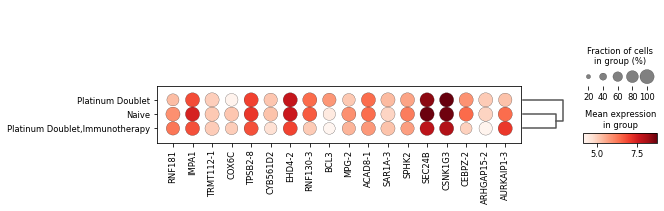

In [25]:
# now we can use the plot functions of scanpy
sc.pl.dotplot(adata, highExprGenes, 'treatment', dendrogram=True)

In [26]:
adata.obs.treatment.value_counts()

Platinum Doublet                  16
Platinum Doublet,Immunotherapy    14
Naive                             13
Name: treatment, dtype: int64

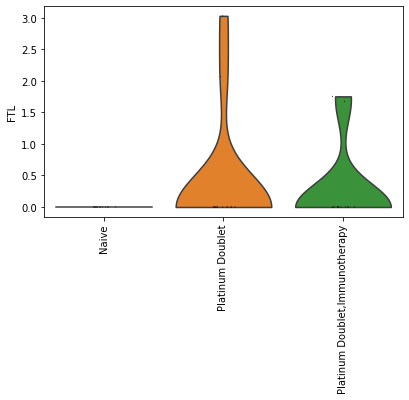

In [27]:
sc.pl.violin(adata, 'FTL', groupby='treatment', rotation=90)

Looks good that TPSB2 is one of the high expressing genes, it's 
associated with Mast cells.
https://pubmed.ncbi.nlm.nih.gov/22235124/

In [ ]:
# We have pulled a subset of cells outof BQ and constructed an AnnData object.

# 5. Relevant Citations and Links